# Data import

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None) # Show all the columns
df = pd.read_csv('/content/readyformodel_V2.csv')
df.head()

,won,pim,powerPlayGoals,faceOffWinPercentage,shots,goals,takeaways,hits,blockedShots,giveaways,missedShots,penalties,timeOnIce,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,hoa_away,hoa_home,settledIn_OT,settledIn_REG,startRinkSide_left,startRinkSide_right,goalieReplacement_No,goalieReplacement_Yes
0,0,2.00,0.67,50.9,8.0,0.0,1.0,14.0,3.0,6.0,4.0,1.0,330.28,280.46,18.52,31.30,1,0,0,1,1,0,0,1
1,1,2.67,0.67,49.1,8.0,3.0,3.0,5.0,3.0,7.0,0.0,1.0,327.11,278.93,25.04,23.15,0,1,0,1,1,0,1,0
2,1,2.00,0.33,43.8,11.0,0.0,0.0,4.0,6.0,2.0,6.0,1.0,334.07,293.20,9.48,31.39,1,0,1,0,0,1,1,0
3,0,2.67,0.33,56.2,12.0,1.0,2.0,4.0,8.0,0.0,3.0,3.0,333.07,296.11,25.11,11.85,0,1,1,0,0,1,1,0
4,1,3.00,0.33,45.7,9.0,0.0,3.0,4.0,7.0,7.0,3.0,2.0,328.89,281.57,17.78,29.54,1,0,0,1,1,0,1,0


In [3]:
# Round pim, powerPlayOpportunities, and powerPlayGoals to integer
df = df.round({"pim":0,"powerPlayOpportunities":0,"powerPlayGoals":0})
df.head()

,won,pim,powerPlayGoals,faceOffWinPercentage,shots,goals,takeaways,hits,blockedShots,giveaways,missedShots,penalties,timeOnIce,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,hoa_away,hoa_home,settledIn_OT,settledIn_REG,startRinkSide_left,startRinkSide_right,goalieReplacement_No,goalieReplacement_Yes
0,0,2.0,1.0,50.9,8.0,0.0,1.0,14.0,3.0,6.0,4.0,1.0,330.28,280.46,18.52,31.30,1,0,0,1,1,0,0,1
1,1,3.0,1.0,49.1,8.0,3.0,3.0,5.0,3.0,7.0,0.0,1.0,327.11,278.93,25.04,23.15,0,1,0,1,1,0,1,0
2,1,2.0,0.0,43.8,11.0,0.0,0.0,4.0,6.0,2.0,6.0,1.0,334.07,293.20,9.48,31.39,1,0,1,0,0,1,1,0
3,0,3.0,0.0,56.2,12.0,1.0,2.0,4.0,8.0,0.0,3.0,3.0,333.07,296.11,25.11,11.85,0,1,1,0,0,1,1,0
4,1,3.0,0.0,45.7,9.0,0.0,3.0,4.0,7.0,7.0,3.0,2.0,328.89,281.57,17.78,29.54,1,0,0,1,1,0,1,0


# CausalML

## Import packages

In [4]:
!pip install causalml
import scipy.stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier


from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor
from causalml.inference.meta import BaseSRegressor

import shap
import matplotlib.pyplot as plt

import time
from causalml.metrics import *
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import causalml
print(causalml.__version__)

0.12.1


In [6]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.0.2


## Identify treatment, x, y variables

In [7]:
# Target variable (y)
y = df['won']

In [8]:
# Control variables (X)
X = df.copy()
X = X.drop(columns = ['won', 'hoa_home'])
X

,pim,powerPlayGoals,faceOffWinPercentage,shots,goals,takeaways,hits,blockedShots,giveaways,missedShots,penalties,timeOnIce,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,hoa_away,settledIn_OT,settledIn_REG,startRinkSide_left,startRinkSide_right,goalieReplacement_No,goalieReplacement_Yes
0,2.0,1.0,50.9,8.0,0.0,1.0,14.0,3.0,6.0,4.0,1.0,330.28,280.46,18.52,31.30,1,0,1,1,0,0,1
1,3.0,1.0,49.1,8.0,3.0,3.0,5.0,3.0,7.0,0.0,1.0,327.11,278.93,25.04,23.15,0,0,1,1,0,1,0
2,2.0,0.0,43.8,11.0,0.0,0.0,4.0,6.0,2.0,6.0,1.0,334.07,293.20,9.48,31.39,1,1,0,0,1,1,0
3,3.0,0.0,56.2,12.0,1.0,2.0,4.0,8.0,0.0,3.0,3.0,333.07,296.11,25.11,11.85,0,1,0,0,1,1,0
4,3.0,0.0,45.7,9.0,0.0,3.0,4.0,7.0,7.0,3.0,2.0,328.89,281.57,17.78,29.54,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51552,7.0,0.0,58.7,18.0,0.0,12.0,18.0,8.0,8.0,10.0,4.0,330.94,272.09,14.41,44.44,0,0,1,0,1,1,0
51553,1.0,0.0,49.0,4.0,4.0,4.0,28.0,18.0,0.0,4.0,2.0,331.11,322.22,8.89,0.00,1,0,1,0,1,1,0
51554,0.0,0.0,51.0,24.0,0.0,10.0,22.0,4.0,10.0,2.0,0.0,337.15,326.04,0.00,11.11,0,0,1,0,1,1,0
51555,1.0,0.0,49.0,4.0,4.0,4.0,28.0,18.0,0.0,4.0,2.0,331.11,322.22,8.89,0.00,1,0,1,0,1,1,0


In [9]:
# Define a function that will label for treatment
def treat(df):
    if df['hoa_home'] == 1:
        return 1
    return 0
df['Treatment'] = df.apply(lambda df: treat(df), axis=1)

# define treatment
treatment = df['Treatment']
treatment

0        0
1        1
2        0
3        1
4        0
        ..
51552    1
51553    0
51554    1
51555    0
51556    1
Name: Treatment, Length: 51557, dtype: int64

In [10]:
# Propensity calculation
n_wins = len(df[df["won"]==1])
n_treated_H = len(df[(df["won"]==1) & (df["Treatment"]==1)])
e_wins = n_treated_H/n_wins

n_loses = len(df[df["won"]==0])
n_treated_A = len(df[(df["won"]==0) & (df["Treatment"]==0)])
e_loses = n_treated_A/n_loses

df["propensity"] = df["won"]*e_wins + (1-df["won"])*e_loses
df["propensity"].value_counts()

0.547240    26376
0.547834    25181
Name: propensity, dtype: int64

In [11]:
df.Treatment = df.Treatment.replace({1:"treatment_A",0:"control"})
df.Treatment

0            control
1        treatment_A
2            control
3        treatment_A
4            control
            ...     
51552    treatment_A
51553        control
51554    treatment_A
51555        control
51556    treatment_A
Name: Treatment, Length: 51557, dtype: object

In [12]:
# w_multi
w_multi = df.Treatment

In [13]:
# Feature name
feature_names = []
for col in X.columns:
    feature_names.append(col)
feature_names

['pim',
 'powerPlayGoals',
 'faceOffWinPercentage',
 'shots',
 'goals',
 'takeaways',
 'hits',
 'blockedShots',
 'giveaways',
 'missedShots',
 'penalties',
 'timeOnIce',
 'evenTimeOnIce',
 'shortHandedTimeOnIce',
 'powerPlayTimeOnIce',
 'hoa_away',
 'settledIn_OT',
 'settledIn_REG',
 'startRinkSide_left',
 'startRinkSide_right',
 'goalieReplacement_No',
 'goalieReplacement_Yes']

## Modelling

### LRSRegressor with SLearner, "auto" method

In [14]:
# SLearner & Auto
# Ready-to-use S-Learner using LinearRegression
# Implementing S Learner 
base_algo = LGBMRegressor()
slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.05591879])

In [15]:
# Implementing Prediction based on model
slearner_tau = slearner.fit_predict(X, w_multi, y)

In [16]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': timeOnIce                0.447677
 goals                    0.112133
 pim                      0.098261
 shortHandedTimeOnIce     0.078806
 goalieReplacement_No     0.064702
 powerPlayTimeOnIce       0.056856
 powerPlayGoals           0.039315
 settledIn_OT             0.035167
 penalties                0.019066
 hits                     0.013127
 evenTimeOnIce            0.013115
 takeaways                0.004643
 blockedShots             0.004368
 faceOffWinPercentage     0.003381
 giveaways                0.002831
 shots                    0.002671
 settledIn_REG            0.002187
 missedShots              0.001042
 startRinkSide_left       0.000470
 goalieReplacement_Yes    0.000163
 hoa_away                 0.000017
 startRinkSide_right      0.000000
 dtype: float64}

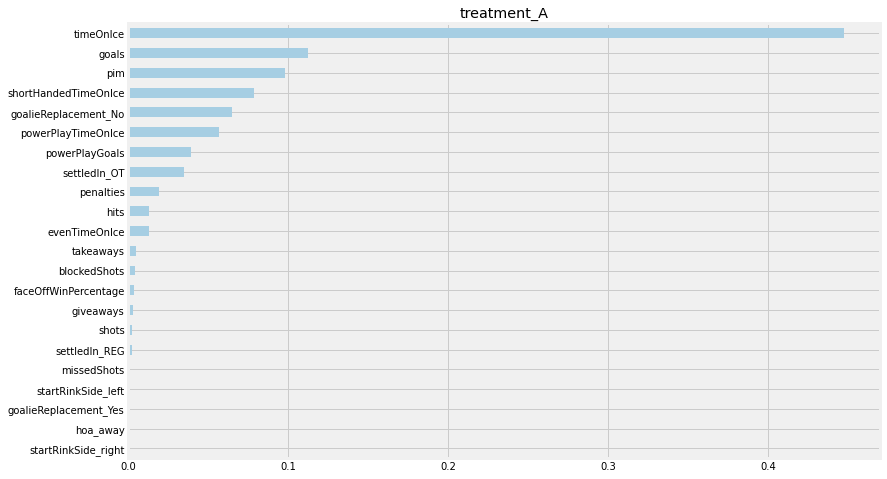

In [17]:
# Auto feature importance plot from Github example.
slearner.plot_importance(X=X,
                        tau=slearner_tau,
                        normalize = True,
                        method = 'auto',
                        features = feature_names)

### LRSRegressor with SLearner, "permutation" method

In [18]:
# Permutation method
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': timeOnIce                0.771578
 shortHandedTimeOnIce     0.274947
 pim                      0.269852
 goals                    0.266111
 settledIn_OT             0.215275
 goalieReplacement_No     0.160484
 powerPlayTimeOnIce       0.122383
 powerPlayGoals           0.074927
 penalties                0.039721
 hits                     0.021598
 evenTimeOnIce            0.021235
 blockedShots             0.009688
 faceOffWinPercentage     0.007386
 takeaways                0.007226
 shots                    0.005456
 giveaways                0.004372
 missedShots              0.001835
 settledIn_REG            0.001361
 startRinkSide_left       0.000799
 hoa_away                 0.000006
 startRinkSide_right      0.000000
 goalieReplacement_Yes    0.000000
 dtype: float64}

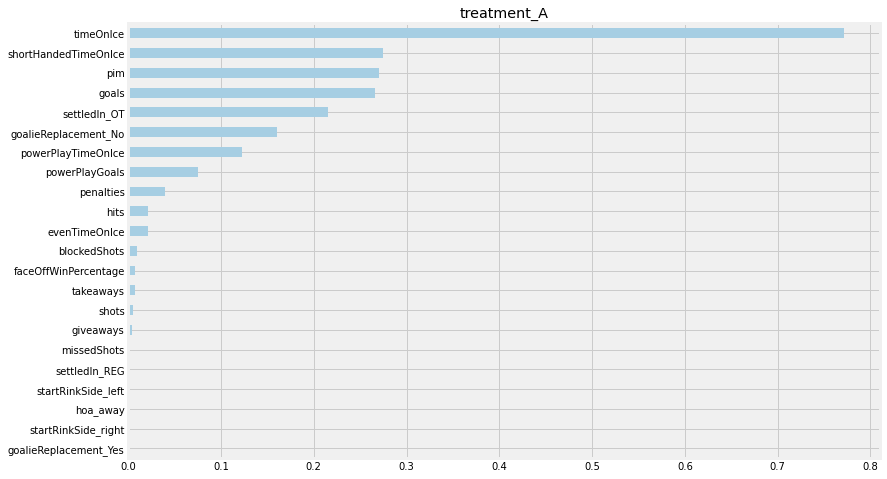

In [19]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### LRSRegressor with SLearner, Shapley Values

In [20]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[-7.52735910e-03,  8.47844363e-04,  1.29754027e-04, ...,
          0.00000000e+00, -1.38171890e-02, -4.43769833e-04],
        [-5.09296353e-03, -2.74859657e-03,  1.89987488e-04, ...,
          0.00000000e+00,  1.22124357e-03,  1.38540409e-05],
        [-7.09360192e-03,  1.08564431e-03,  2.29771762e-04, ...,
          0.00000000e+00,  1.70932790e-03,  3.66979031e-05],
        ...,
        [ 2.28740613e-03,  1.02414503e-03,  2.59426668e-04, ...,
          0.00000000e+00,  1.97194053e-03,  5.83527771e-05],
        [-2.47783233e-03, -2.27339455e-05,  5.40754083e-04, ...,
          0.00000000e+00,  1.46550150e-03,  2.08331480e-05],
        [ 2.28740613e-03,  1.02414503e-03,  2.59426668e-04, ...,
          0.00000000e+00,  1.97194053e-03,  5.83527771e-05]])}

In [21]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([1.02654515e-02, 2.95107592e-03, 6.98513753e-04, 4.63233499e-04,
       8.95163718e-03, 4.16801139e-04, 2.13950644e-03, 8.39823093e-04,
       7.85464537e-04, 2.20360590e-04, 2.89962260e-03, 2.07232030e-02,
       1.80658224e-03, 6.33817745e-03, 6.31101956e-03, 1.68448367e-06,
       4.52593983e-03, 9.49463633e-04, 1.16438539e-04, 0.00000000e+00,
       4.94568834e-03, 6.60515167e-05])

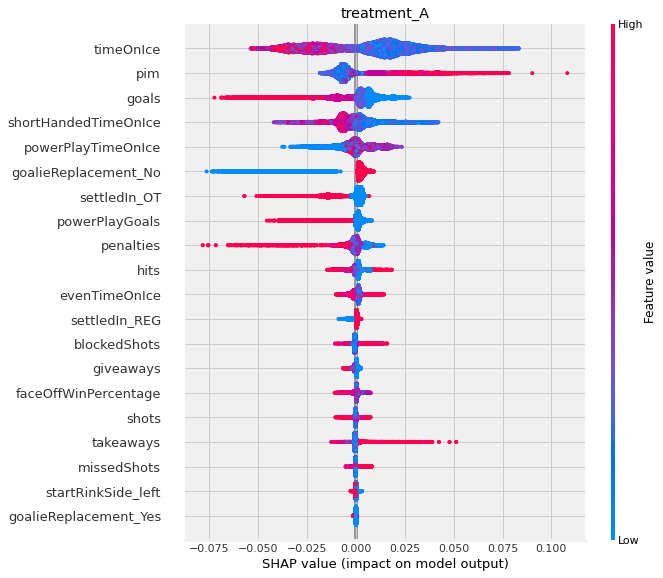

In [22]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

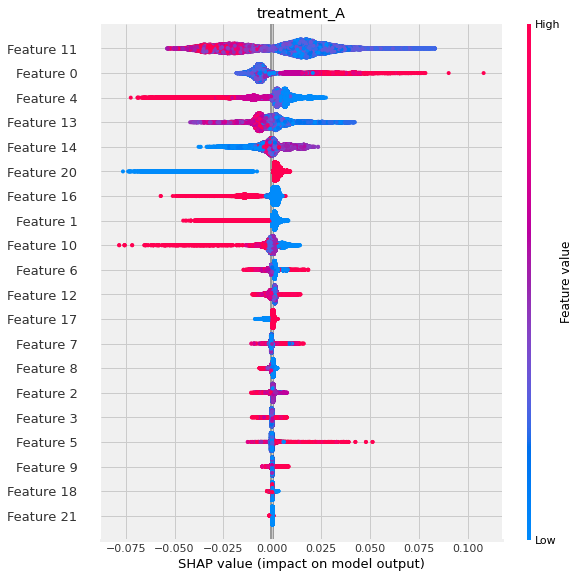

In [23]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

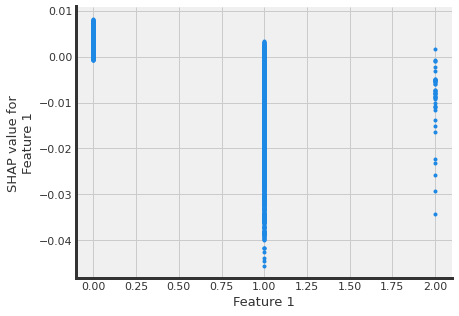

In [24]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

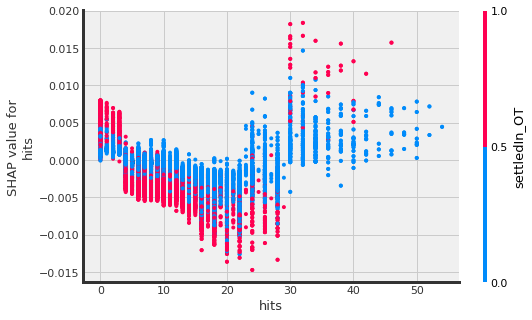

In [25]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=6,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

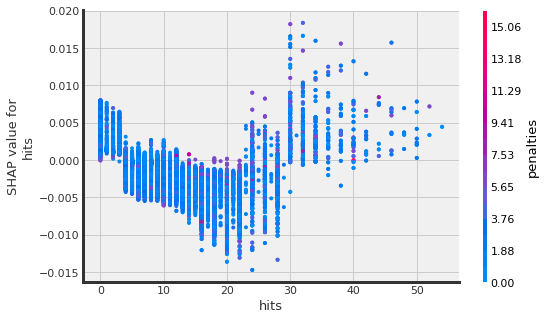

In [26]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=6,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

### LRSRegressor with TLearner, "auto" method

In [27]:
learner_t = LRSRegressor()
cate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print(cate_t)
print('ATE estimate: {:.03f}'.format(cate_t[0][0]))
print('ATE lower bound: {:.03f}'.format(cate_t[1][0]))
print('ATE upper bound: {:.03f}'.format(cate_t[2][0]))

tlearner_tau = learner_t.fit_predict(X, treatment, y)

(array([-1.31909527]), array([-1.76203469]), array([-0.87615585]))
ATE estimate: -1.319
ATE lower bound: -1.762
ATE upper bound: -0.876


In [28]:
learner_t.get_importance(X=X, 
                         tau=tlearner_tau,
                         normalize=True, 
                         method='auto',
                         features = feature_names)

{1: pim                      1.0
 powerPlayGoals           0.0
 goalieReplacement_No     0.0
 startRinkSide_right      0.0
 startRinkSide_left       0.0
 settledIn_REG            0.0
 settledIn_OT             0.0
 hoa_away                 0.0
 powerPlayTimeOnIce       0.0
 shortHandedTimeOnIce     0.0
 evenTimeOnIce            0.0
 timeOnIce                0.0
 penalties                0.0
 missedShots              0.0
 giveaways                0.0
 blockedShots             0.0
 hits                     0.0
 takeaways                0.0
 goals                    0.0
 shots                    0.0
 faceOffWinPercentage     0.0
 goalieReplacement_Yes    0.0
 dtype: float64}

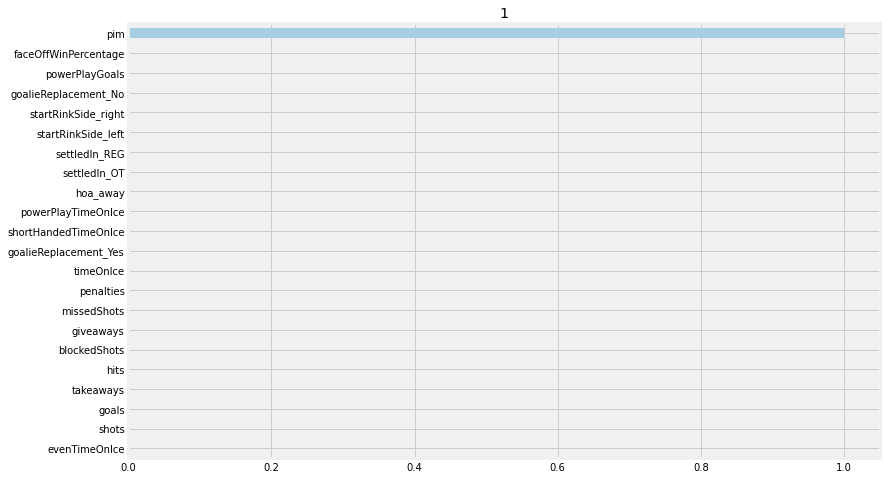

In [29]:
learner_t.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### XGBTRegressor with TLearner, "auto" method

In [30]:
# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

[02:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the ready-to-use XGBTRegressor class
(array([0.06566795]), array([0.05841266]), array([0.07292325]))


In [31]:
learner_t.get_importance(X=X, 
                        tau=cate_t,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{1: timeOnIce                0.411656
 goals                    0.120368
 pim                      0.113889
 settledIn_OT             0.065543
 shortHandedTimeOnIce     0.051236
 powerPlayGoals           0.048918
 powerPlayTimeOnIce       0.047764
 goalieReplacement_No     0.046034
 penalties                0.027953
 evenTimeOnIce            0.025156
 hits                     0.020155
 faceOffWinPercentage     0.006490
 blockedShots             0.004022
 missedShots              0.003646
 giveaways                0.003381
 shots                    0.002608
 takeaways                0.001054
 startRinkSide_left       0.000085
 settledIn_REG            0.000043
 hoa_away                 0.000000
 startRinkSide_right      0.000000
 goalieReplacement_Yes    0.000000
 dtype: float64}

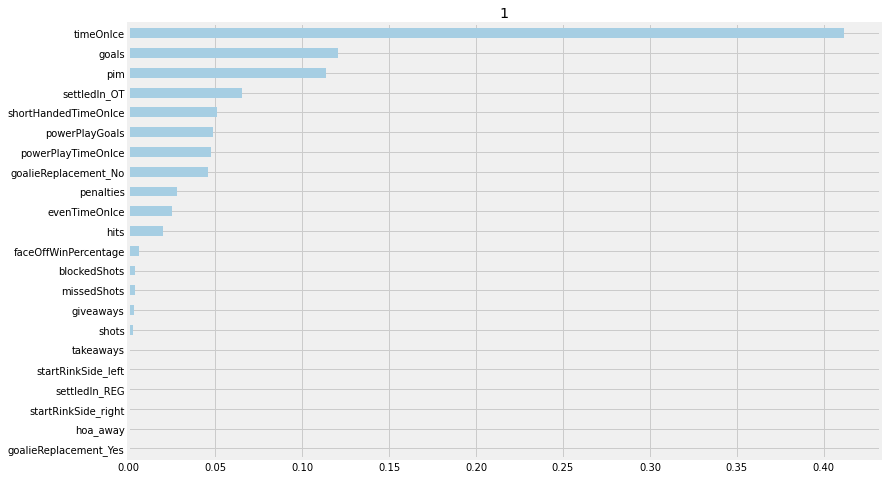

In [32]:
learner_t.plot_importance(X=X, 
                         tau=cate_t, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### XGBTRegressor with X Learner with propensity score input

In [33]:
# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
e = df.propensity
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y,p=e)
print('Using the BaseXRegressor class and using XGB:')
print(cate_x)

[02:21:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB:
[[ 0.04534055]
 [ 0.07106629]
 [-0.00464568]
 ...
 [-0.00775253]
 [ 0.02518425]
 [-0.00775253]]


### XGBTRegressor with R Learner with propensity score input 

In [34]:
# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y,p=e)

[02:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### A distribution plot of different learners of XGBTRegressor

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


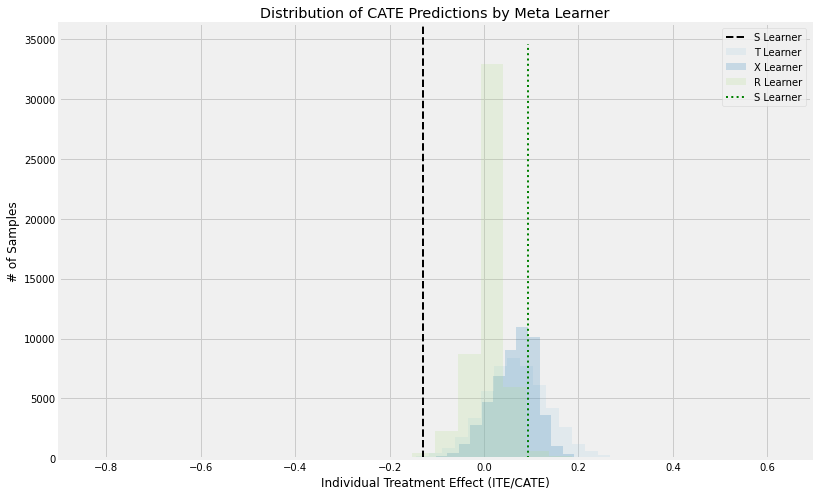

In [35]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
# Consider having this
plt.vlines(cate_t[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
# Or this
plt.axvline(x=-0.130 ,color="black", linestyle="--", label = "S Learner", linewidth=2)

plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

### Uplift Tree/Forest

In [36]:
# UpliftTreeClassifier
from causalml.dataset import make_uplift_classification

df, x_names = make_uplift_classification()

In [37]:
uplift_tree = UpliftTreeClassifier(control_name='control')

new = df.copy()
control = new.drop(columns= ['treatment_group_key', 'conversion', 'treatment_effect'])
uplift_tree.fit(X=control.values,
                treatment=new['treatment_group_key'].values,
                y=new['conversion'].values)

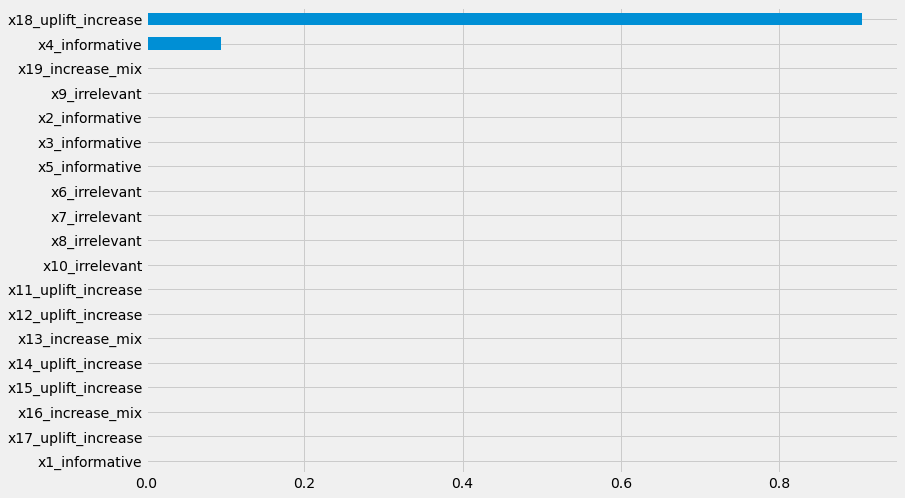

In [38]:
pd.Series(uplift_tree.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))

In [39]:
# UpliftRandomForestClassifier
uplift_rf = UpliftRandomForestClassifier(control_name='control')

uplift_rf.fit(X=control.values,
                treatment=new['treatment_group_key'].values,
                y=new['conversion'].values)

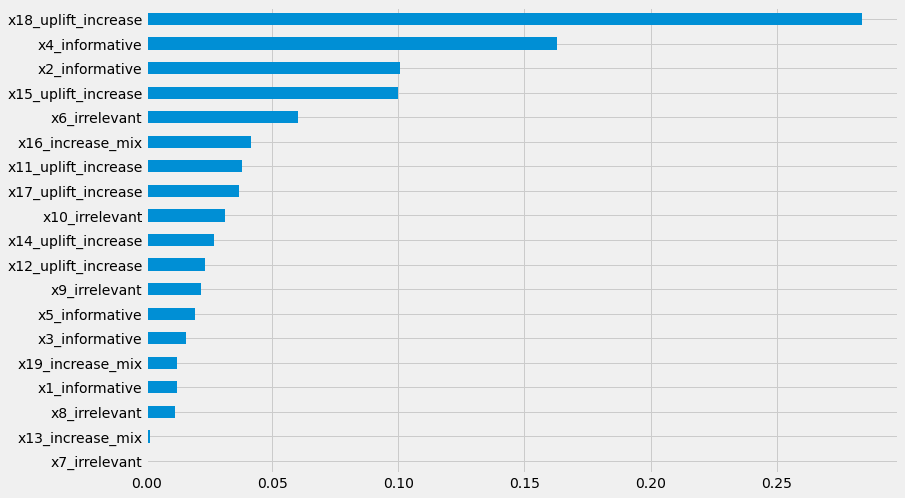

In [40]:
pd.Series(uplift_rf.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))